In [1]:
library(tidyverse)  
library(lubridate)
library(dplyr)
library(readr)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


**Introduction:**
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and fully describe the dataset that was used to answer the question

## **Methods & Results:**
- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
- your report should include code which:
- loads data 
- wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
- note: all figures should have a figure number and a legend

### **Load Data** 

In [2]:
players <- read_csv("https://raw.githubusercontent.com/Elvis614412/Dsci-100-group-project/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/Elvis614412/Dsci-100-group-project/refs/heads/main/sessions.csv")

merged_data <- left_join(players,sessions, by = "hashedEmail")

merged_data <- merged_data|>
    select(-hashedEmail,-original_start_time,-original_end_time)
    merged_data$Age[is.na(merged_data$Age)] <- mean(merged_data$Age, na.rm = TRUE)

head(merged_data, 5)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,name,gender,Age,start_time,end_time
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
Pro,TRUE,30.3,Morgan,Male,9,08/08/2024 00:21,08/08/2024 01:35
Pro,TRUE,30.3,Morgan,Male,9,09/09/2024 22:30,09/09/2024 22:37
Pro,TRUE,30.3,Morgan,Male,9,08/08/2024 02:41,08/08/2024 03:25
Pro,TRUE,30.3,Morgan,Male,9,10/09/2024 15:07,10/09/2024 15:29
Pro,TRUE,30.3,Morgan,Male,9,05/05/2024 22:21,05/05/2024 23:17


### **Summary & Visualization of Dataset for Q1**

1. Do older players spend more time per session? (age vs average session duration)

In [6]:
merged_data <- merged_data|>
    mutate(
        start_time = as.POSIXct(start_time, format = "%m/%d/%Y %H:%M"),
        end_time = as.POSIXct(end_time, format = "%m/%d/%Y %H:%M"),
        session_duration = as.numeric(difftime(end_time, start_time, units = "mins"))
    )

name_order <- merged_data |>
  count(name, sort = TRUE) |>
  pull(name)

merged_data$name <- factor(merged_data$name, levels = name_order)

merged_data <- merged_data |>
  arrange(name,start_time)

# merged_data <- merged_data |>
#     filter(name == "Morgan") |>
#     arrange(start_time)

merged_data_clean <- merged_data |>
  filter(session_duration <= 1440 ,!is.na(start_time),!is.na(end_time))

merged_data2 <- merged_data_clean |> 
    group_by(name,Age,experience,subscribe) |>
    summarize(average_playtime = mean(session_duration),.groups = "drop")

merged_data2 <- merged_data2 |>
    select(-name,-experience,-subscribe)

merged_data2 <- merged_data2 |>
    mutate(
        Age = as.integer(Age),
        average_playtime = round(average_playtime,2)
    ) |>
    arrange(Age)

average_by_age <- merged_data2|> 
    group_by(Age) |>
    summarize(average_playtime = mean(average_playtime),.groups = "drop")

average_by_age <- average_by_age |> 
    mutate(
        average_playtime = round(average_playtime)
    )

head(average_by_age,5)



Age,average_playtime
<int>,<dbl>
9,57
10,17
11,18
12,34
14,20


To calculate the average playtime per session, the start_time and end_time variables were first converted from factors to appropriate time formats. 

Before performing the calculation, **I identified the outliers represented non-overlapping, extremely long sessions** and were unlikely to affect the analysis.

**The outliers were extremly long sessions which is saying that some player played almost a month**. I pick specific player "Morgan" who appeared to have played for nearly a month, and I confirmed that this was due to erroneous data. **A few other players also exhibited similar issues**. To ensure data quality, **I filtered out any sessions longer than one day (1440 minutes).**

After cleaning the data, I retained only the necessary columns (Age, average_playtime) and converted the data types to integer and double (rounded to two decimal places) to improve readability and analysis.


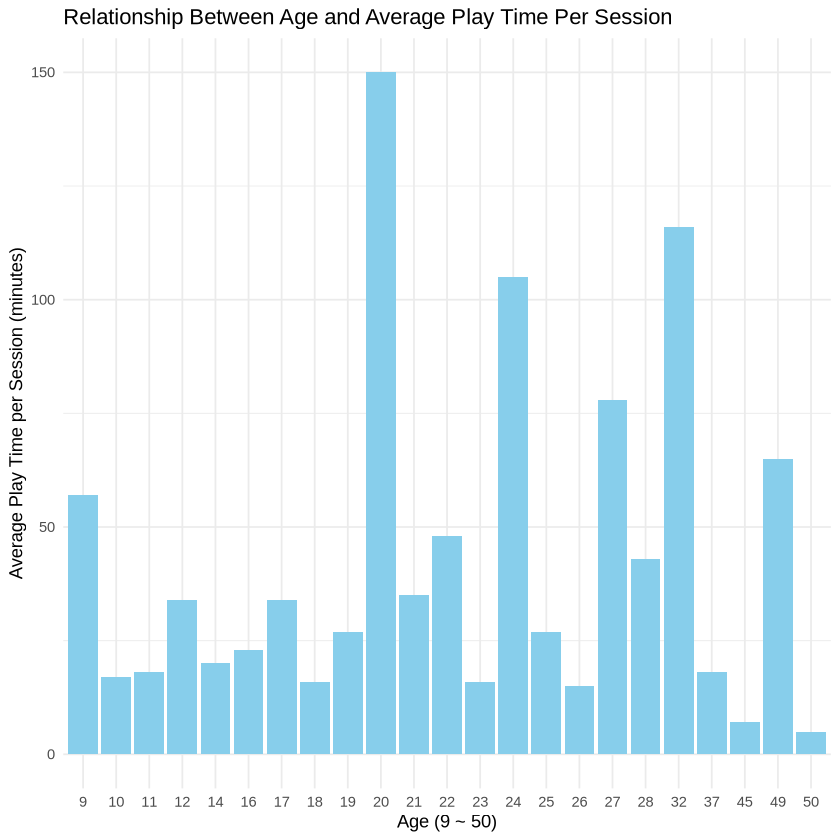

In [10]:
age_plot <- average_by_age |>
    ggplot(aes(x = factor(Age), y = average_playtime)) +
    geom_bar(stat = "identity", fill = "skyblue") + 
    labs(
        x = "Age (9 ~ 50)",
        y = "Average Play Time per Session (minutes)",
        title = "Relationship Between Age and Average Play Time Per Session"
    ) +
    theme_minimal() 

age_plot

In [8]:
merged_data2 <- merged_data2 |>
  mutate(age_group = case_when(
    Age >= 10 & Age < 20 ~ "10s",
    Age >= 20 & Age < 30 ~ "20s",
    Age >= 30 & Age < 40 ~ "30s",
    Age >= 40 & Age <= 59 ~ "40s~50s",
    TRUE ~ NA_character_
  ))

head(merged_data2,5)

grouped_playtime <- merged_data2 |>
  filter(!is.na(age_group)) |>
  group_by(age_group) |>
  summarize(avg_playtime = round(mean(average_playtime), 2))


Age,average_playtime,age_group
<int>,<dbl>,<chr>
9,57.28,NA
10,17.00,10s
11,18.00,10s
12,34.00,10s
14,30.14,10s


After grouping the data by age ranges (e.g., teens, 20s, 30s, etc.), I calculated the average playtime per session for each group. This allowed for a clearer comparison of gaming behavior across different age demographics.

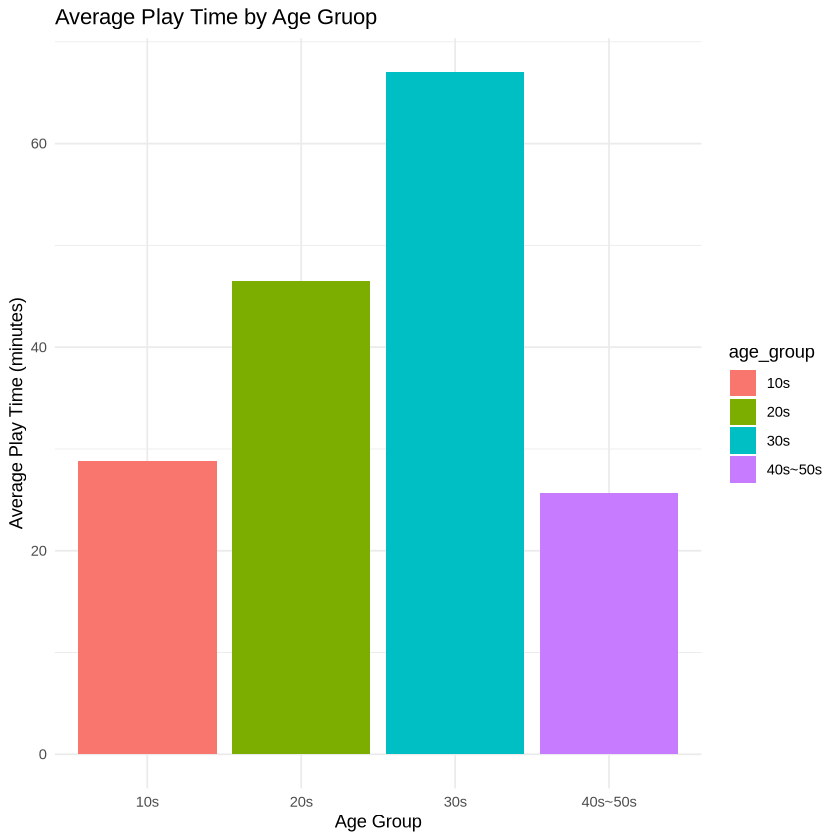

In [12]:
age_plot_by_group <- ggplot(grouped_playtime, aes(x = age_group, y = avg_playtime, fill = age_group)) +
  geom_bar(stat = "identity") +
  labs(title = "Average Play Time by Age Gruop ",
       x = "Age Group",
       y = "Average Play Time (minutes)") +
  theme_minimal()

age_plot_by_group


***Question 1 result***

Based on the analysis of average playtime by age, **20-year-old players recorded the longest average playtime per session at 150 minutes**, followed by **32-year-olds (116 minutes)** and **24-year-olds (105 minutes)**. 

In contrast, **50-year-olds had the shorest average playtime per session at 5 minutes**, with **45 -year-olds (7 minutes)** and **26-year-olds (15 minutes)** also showing relatively short play durations. 

When grouped by age ranges, **players in their 30s had the highest average playtime per session**, followed by those in their **20s, teens (10s), and 40s~50s.** 

These results indicate that **players in their 20s and 30s tend to spend the most time per game session.**

### **Summary & Visualization of Dataset for Q2**

In [3]:
# summary of the data set that is relevant for exploratory data analysis related to the planned analysis
tidy_player_dataset <- players |> 
    mutate(experience = as_factor(experience), 
           subscribe = as_factor(subscribe), 
           gender = as_factor(gender)) |>
    mutate(subscribe = fct_recode(subscribe, "Subscribed" = "TRUE", "Not Subscribed" = "FALSE"))

head(tidy_player_dataset, 5)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,Subscribed,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,Not Subscribed,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,Subscribed,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,Subscribed,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21


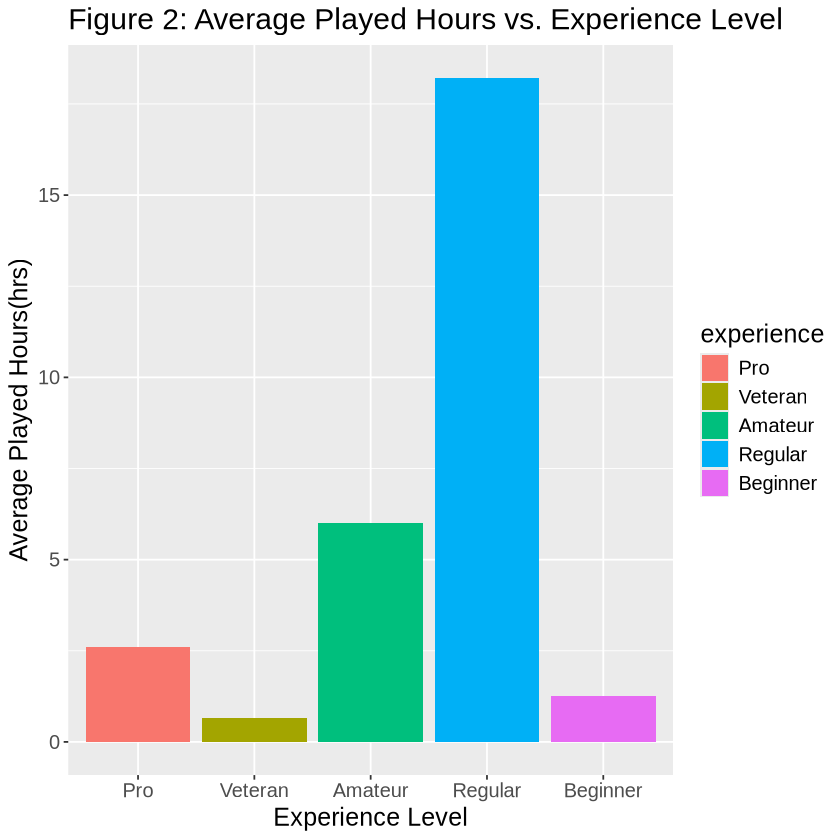

In [4]:
# visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
avg_played_hours <- tidy_player_dataset |>
  group_by(experience) |> 
  summarise(avg_hours = mean(played_hours, na.rm = TRUE))


experience_bar <- ggplot(avg_played_hours, aes(x = experience, y = avg_hours, fill = experience)) +
  geom_bar(stat = "identity") +
  labs(title = "Figure 2: Average Played Hours vs. Experience Level",
       x = "Experience Level",
       y = "Average Played Hours(hrs)") +
  theme(text = element_text(size = 15))

experience_bar

### **Summary & Visualization of Dataset for Q3**

### **Summary & Visualization of Dataset for Q4**

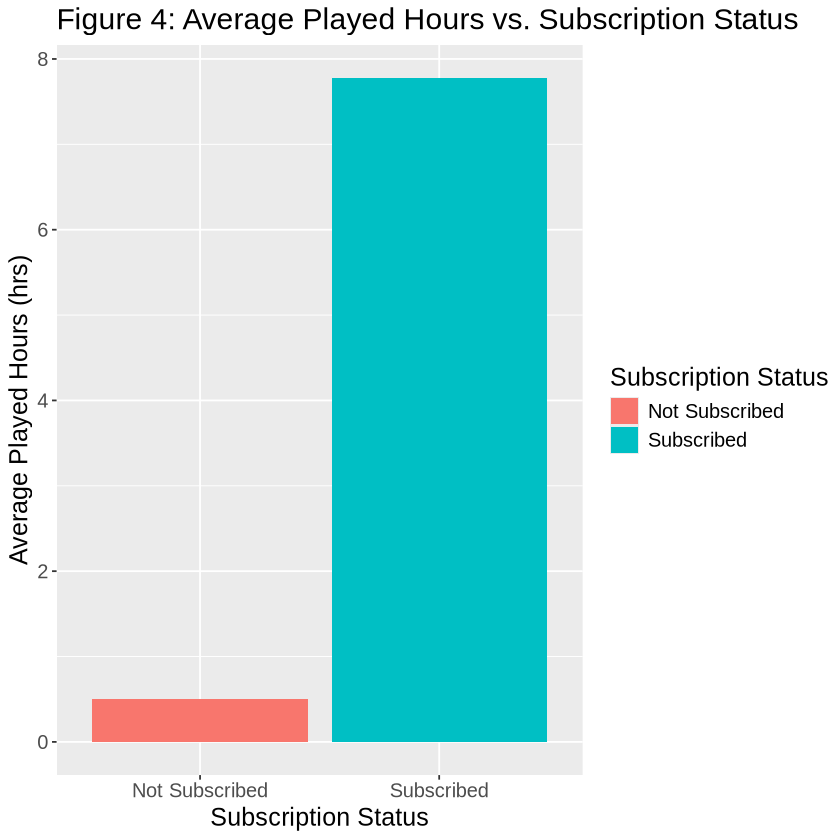

In [5]:
# Compute average played hours by subscription status
avg_played_hours_sub <- tidy_player_dataset |>
  group_by(subscribe) |>
  summarise(avg_hours = mean(played_hours, na.rm = TRUE)) 

# Create the bar plot
sub_bar <- ggplot(avg_played_hours_sub, aes(x = subscribe, y = avg_hours, fill = subscribe)) +
  geom_bar(stat = "identity") +
  labs(title = "Figure 4: Average Played Hours vs. Subscription Status",
       x = "Subscription Status",
       y = "Average Played Hours (hrs)",
       fill = "Subscription Status") +
  theme(text = element_text(size = 15))
sub_bar

**Discussion:**
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

**References**
You may include references if necessary, as long as they all have a consistent citation style.